In [2]:
import utils_general
import utils_coup
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from scipy.linalg import expm
plt.rcParams['figure.figsize'] = [12, 4]
plt.rcParams.update({'font.size': 16})
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",  # Use a LaTeX-compatible serif font
    "font.serif": ["Computer Modern Roman"],  # Or another LaTeX font
})

%load_ext autoreload
%autoreload 2

# Experiment 2: Coupled 3 box model
## a) Forcing applied evenly into all boxes

### $\frac{\partial}{\partial t} C_i = -L_{i,j} C_i + F(t)$

### Integrated solutions to experiments of interest

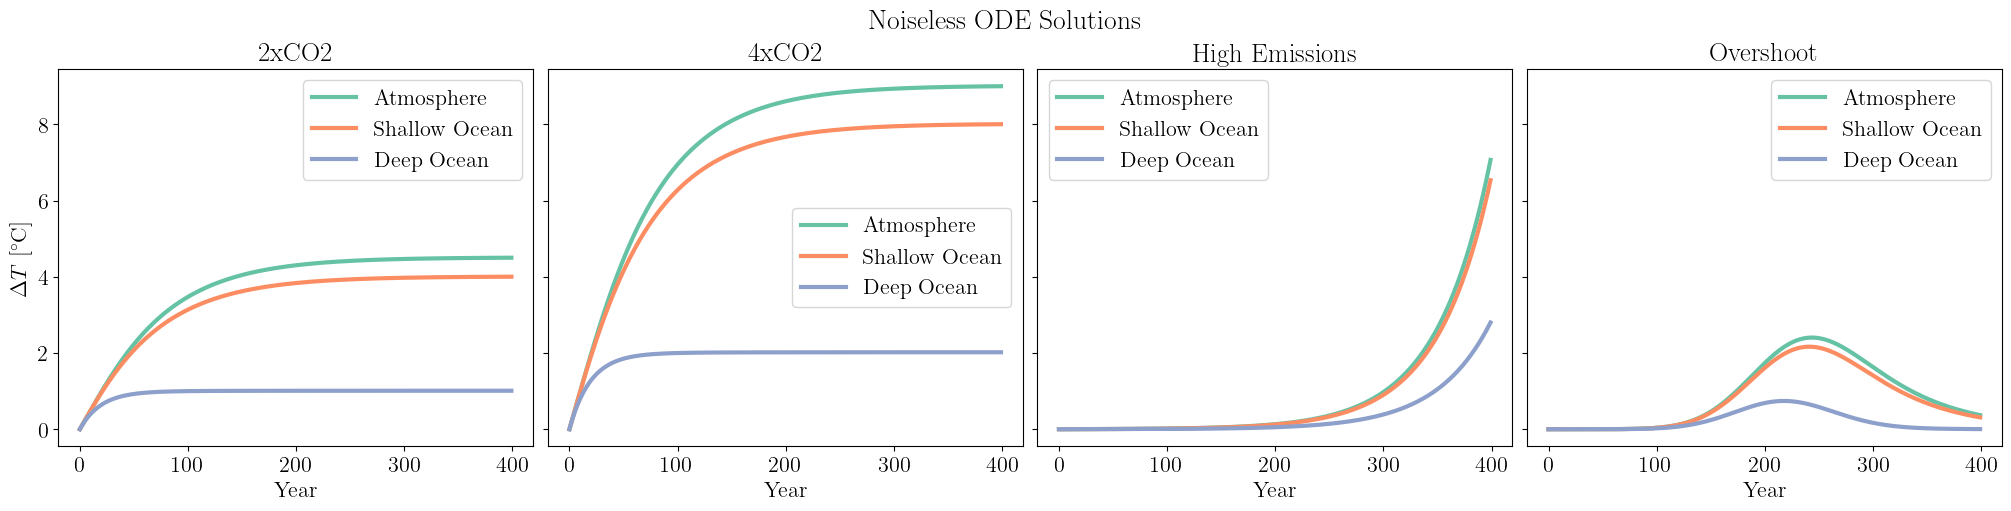

In [103]:
T_ODE, g_ODE, a_ODE = utils_coup.create_coup(noisy=False)

#### Method 1: Direct derivation of Green's function

In [106]:
T_raw_method_1, T_modal_method_1, G_raw_method_1, G_modal_method_1 = utils_coup.method_1_direct(T_ODE, modal=True)

[[2.79455921e-14 5.58911842e-14 2.29834410e-14 1.50410958e-14]
 [2.79455921e-14 5.58911842e-14 2.29834410e-14 1.50410958e-14]
 [2.79455921e-14 5.58911842e-14 2.29834410e-14 1.50410958e-14]
 [2.79455921e-14 5.58911842e-14 2.29834410e-14 1.50410958e-14]]


#### Method 2: Direct inference of L from a dataset

Error from Raw estimation.
	L2 Error, 2xCO2: 0.19396
	L2 Error, 4xCO2: 0.38793
	L2 Error, High Emissions: 0.31089
	L2 Error, Overshoot: 0.15708
Avg. L2 Error: 0.26246

Error from Modal estimation.
	L2 Error, 2xCO2: 0.19396
	L2 Error, 4xCO2: 0.38793
	L2 Error, High Emissions: 0.31089
	L2 Error, Overshoot: 0.15708
Avg. L2 Error: 0.26246



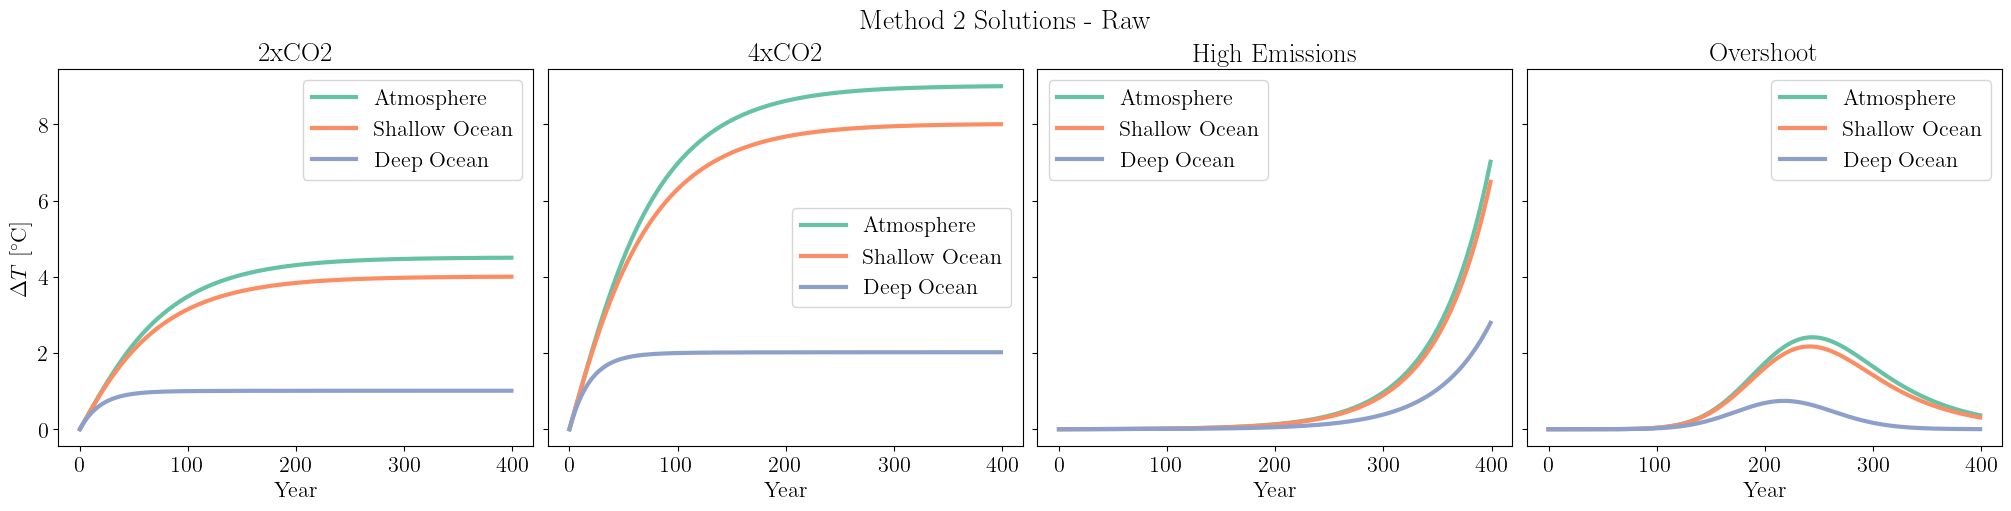

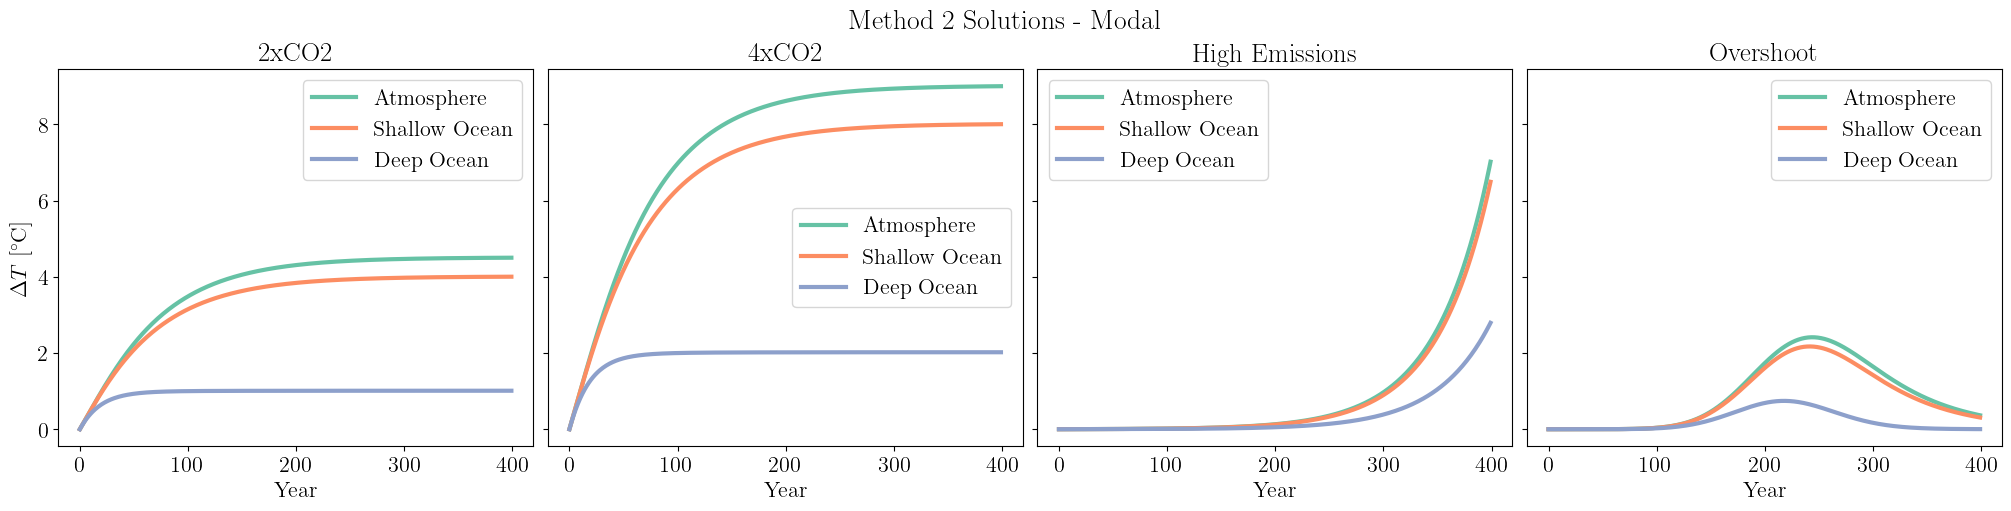

In [5]:
T_raw_method_2, T_modal_method_2, L_raw_method_2, L_modal_method_2 = utils_coup.method_2_L(T_ODE, g_ODE, a_ODE, modal=True)

#### Method 2: SVD-based approach

In [251]:
def calc_L_SVD(w, F, t, k=None):

  w_n = np.copy(w)
  w_n_p = utils_general.calc_derivative(np.copy(w), t)
  U, Sig, Vt = np.linalg.svd(w_n, full_matrices=False)

  if k is not None:
    U = U[:,:k]
    Sig = Sig[:k]
    Vt = Vt[:k,:]

  S = U.T @ (w_n_p - np.tile(F, (len(w), 1))) @ Vt.T @ np.linalg.inv(np.diag(Sig))

  lam, v_S = np.linalg.eig(S)
  v_L = U @ v_S

  return v_L @ np.diag(lam) @ np.linalg.pinv(v_L)

In [252]:
L = {}
for exp in utils_coup.experiments:
  L[exp] = calc_L_SVD(T_ODE[exp], utils_coup.F_all[exp], utils_coup.t, k=2)


Error from Raw estimation.
	L2 Error, 2xCO2: 9.36973
	L2 Error, 4xCO2: 18.73946
	L2 Error, High Emissions: 1.7806
	L2 Error, Overshoot: 2.35598
Avg. L2 Error: 8.06144



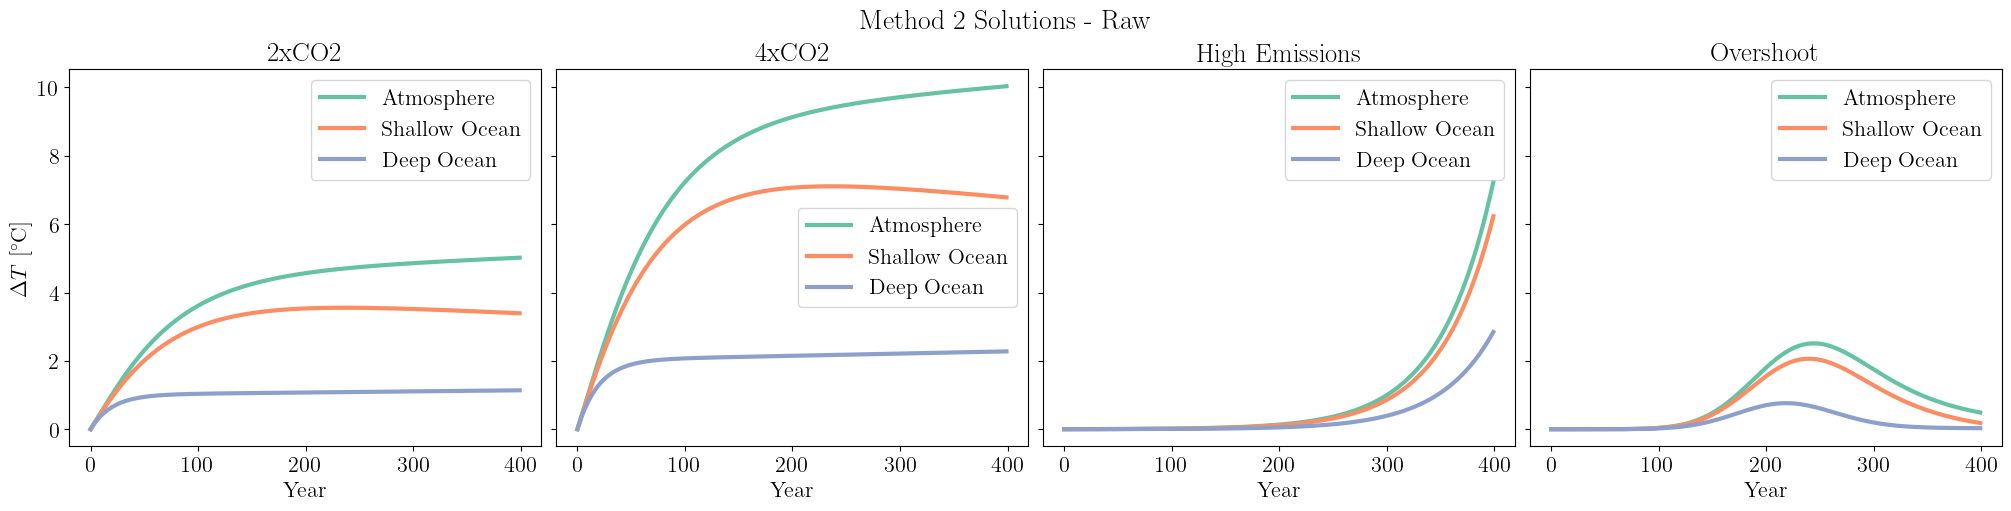

In [253]:
T_raw, T_modal = utils_general.estimate_T_2D(T_ODE, utils_coup.F_all,
                                               utils_coup.experiments, utils_coup.t, 'L',
                                               L, L,
                                               utils_coup.T0, utils_coup.dt)

L2_raw, L2_modal = utils_coup.calc_L2_and_plot(T_ODE, T_raw, utils_coup.t,
                                    utils_coup.experiments, utils_coup.regions,
                                    utils_coup.colors, soln_type='Method 2 Solutions',
                                    modal=False)

#### Method 3: Direct deconvolution of response function from dataset

In [107]:
T_raw_method_3, T_modal_method_3, G_raw_method_3, G_modal_method_3 = utils_coup.method_3_deconv(T_ODE, g_ODE, a_ODE, modal=True)

[[0.00000000e+00 0.00000000e+00 2.05047309e-14 1.48359016e-14]
 [0.00000000e+00 0.00000000e+00 2.05047309e-14 1.48359016e-14]
 [3.03246296e-11 6.06492592e-11 3.63021191e-14 8.15540077e-14]
 [2.06981182e-04 4.13962363e-04 3.05737052e-07 1.74367658e-14]]


#### Method 4: Estimation of response function using only leading timescales

##### a) Single leading order timescale

[ 0.97614839  0.87476018  0.25291023 -0.01253326]
Error from Raw estimation.
	L2 Error, 2xCO2: 4.47361
	L2 Error, 4xCO2: 8.94721
	L2 Error, High Emissions: 0.00434
	L2 Error, Overshoot: 3.51521
Avg. L2 Error: 4.23509



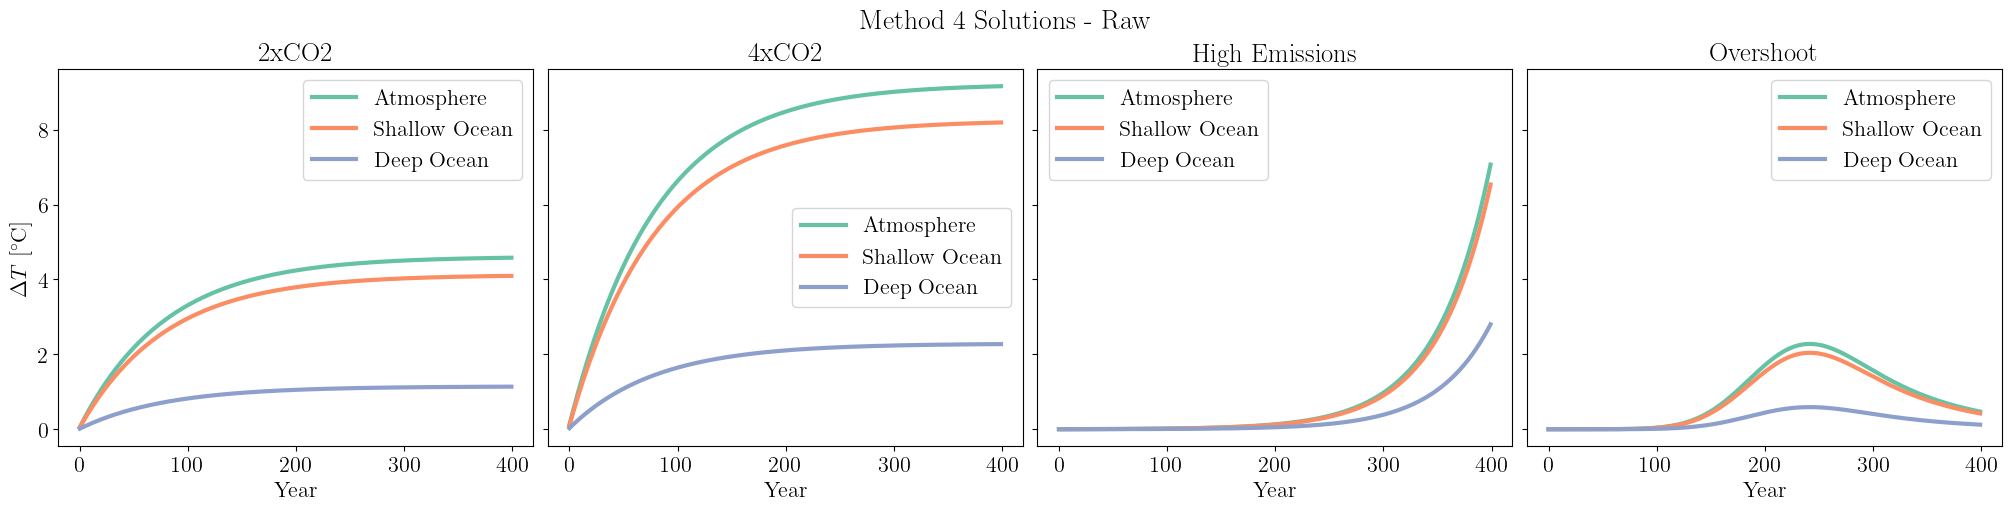

In [27]:
m, k = 1, 3
T_raw_method_4, T_modal_method_4, G_raw_method_4, G_modal_method_4 = utils_coup.method_4_fit(T_ODE, g_ODE, a_ODE, m, k, modal=False)

#### a) Single leading order timescale w/ annealing

In [28]:
m, k = 1, 3
T_raw_method_4, T_modal_method_4, G_raw_method_4, G_modal_method_4 = utils_coup.method_4_fit_anneal(T_ODE, g_ODE, a_ODE, m, k, modal=False)

KeyboardInterrupt: 

In [93]:
exp='2xCO2'
#plt.plot((T_ODE[exp] - T_raw_method_4[exp]).T)
T_residual = T_ODE[exp] - T_raw_method_4[exp]

from scipy.linalg import toeplitz
F_toep = toeplitz(utils_coup.F_all[exp], np.zeros_like(utils_coup.F_all[exp]))

initial_v = np.random.rand(k)  # Flattened eigenvector
initial_lam = np.random.rand(1)      # Eigenvalues
initial_params = np.concatenate([initial_v, initial_lam])  # Combine into a single parameter vector
bounds = [(None, None)] * (k) + [(-1, 0)]

gamma = np.ones(3)

res_raw = minimize(utils_general.opt_v_lam_2D,
                              initial_params,
                              args=(T_residual, utils_coup.F_all[exp], utils_coup.t, 1, 1, gamma),
                              method='L-BFGS-B',
                              bounds=bounds)

G_raw_res = utils_general.apply_v_lam_2D(res_raw.x, utils_coup.t, 1, gamma, 1)
T_new = G_raw_res @ F_toep.T

In [94]:
res_raw.x

array([-0.45846527,  1.7485811 , -0.34444066,  0.        ])

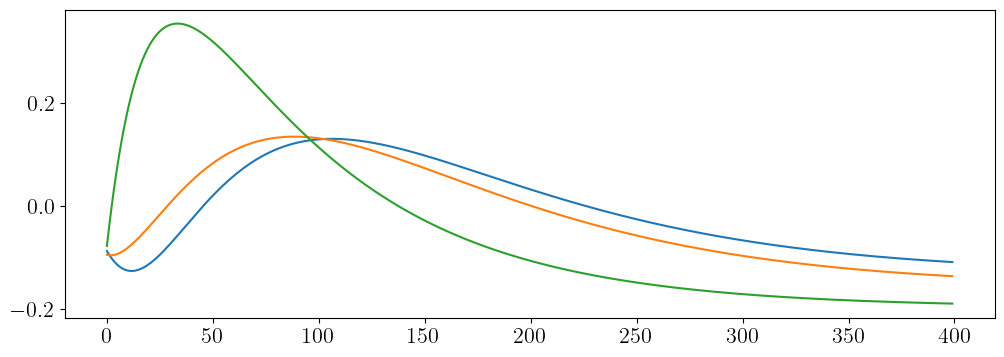

In [89]:
plt.plot(T_ODE[exp].T - T_new.T - T_raw_method_4[exp].T)

[ 0.83176195  0.74375817  0.20638441 -0.0125595 ]
[ 1.0536157   0.94213877  0.26143286 -0.0125595 ]
[ 0.68273834  0.63128779  0.27061494 -0.01251907]
[ 0.78430818  0.70284576  0.20320648 -0.01253326]
Error from Raw estimation.
	L2 Error, 2xCO2: 4.47361
	L2 Error, 4xCO2: 8.94721
	L2 Error, High Emissions: 0.00434
	L2 Error, Overshoot: 3.51521
Avg. L2 Error: 4.23509



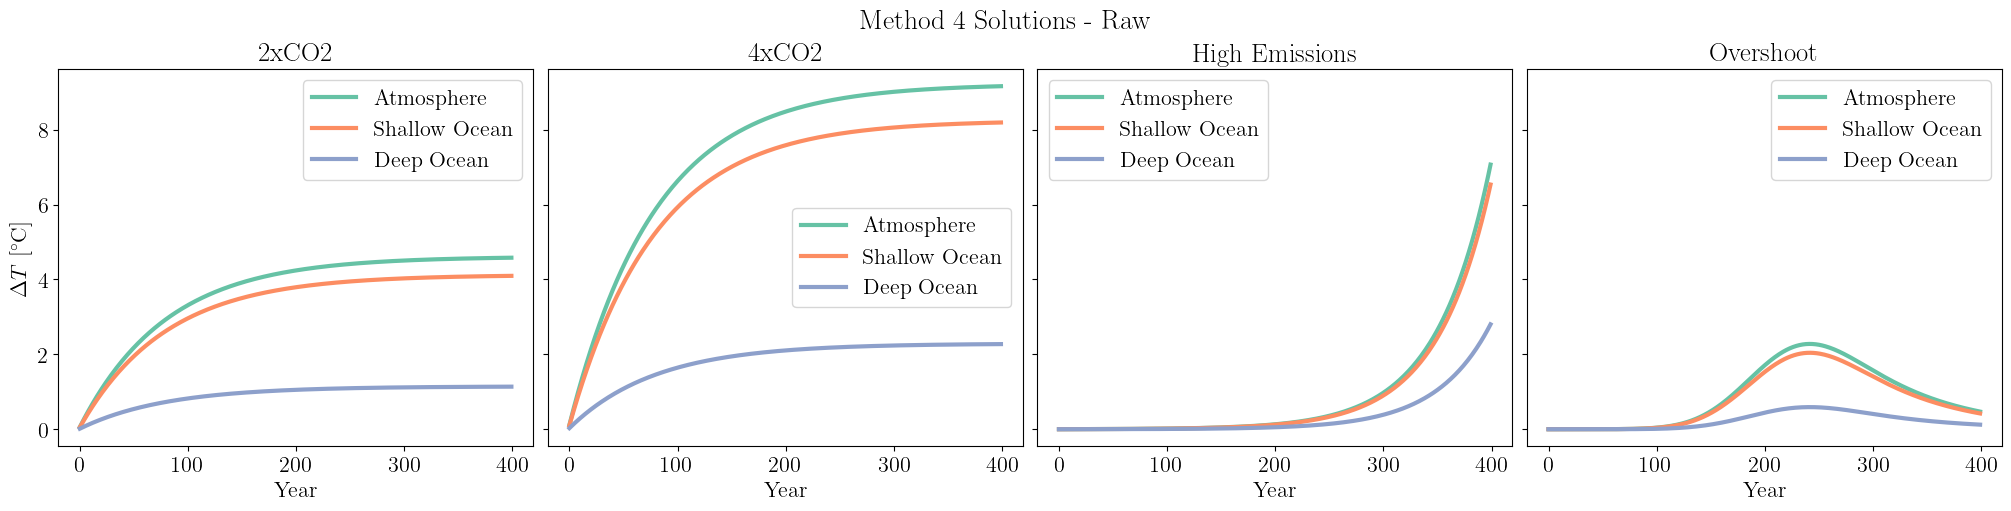

In [91]:
m, k = 1, 3
T_raw_method_4, T_modal_method_4, G_raw_method_4, G_modal_method_4 = utils_coup.method_4_fit_residual(T_ODE, g_ODE, a_ODE, m, k, modal=False)

##### a.ii) Two leading order timescales

Error from Raw estimation.
	L2 Error, 2xCO2: 3.80211
	L2 Error, 4xCO2: 9.14072
	L2 Error, High Emissions: 0.02284
	L2 Error, Overshoot: 3.50321
Avg. L2 Error: 4.11722



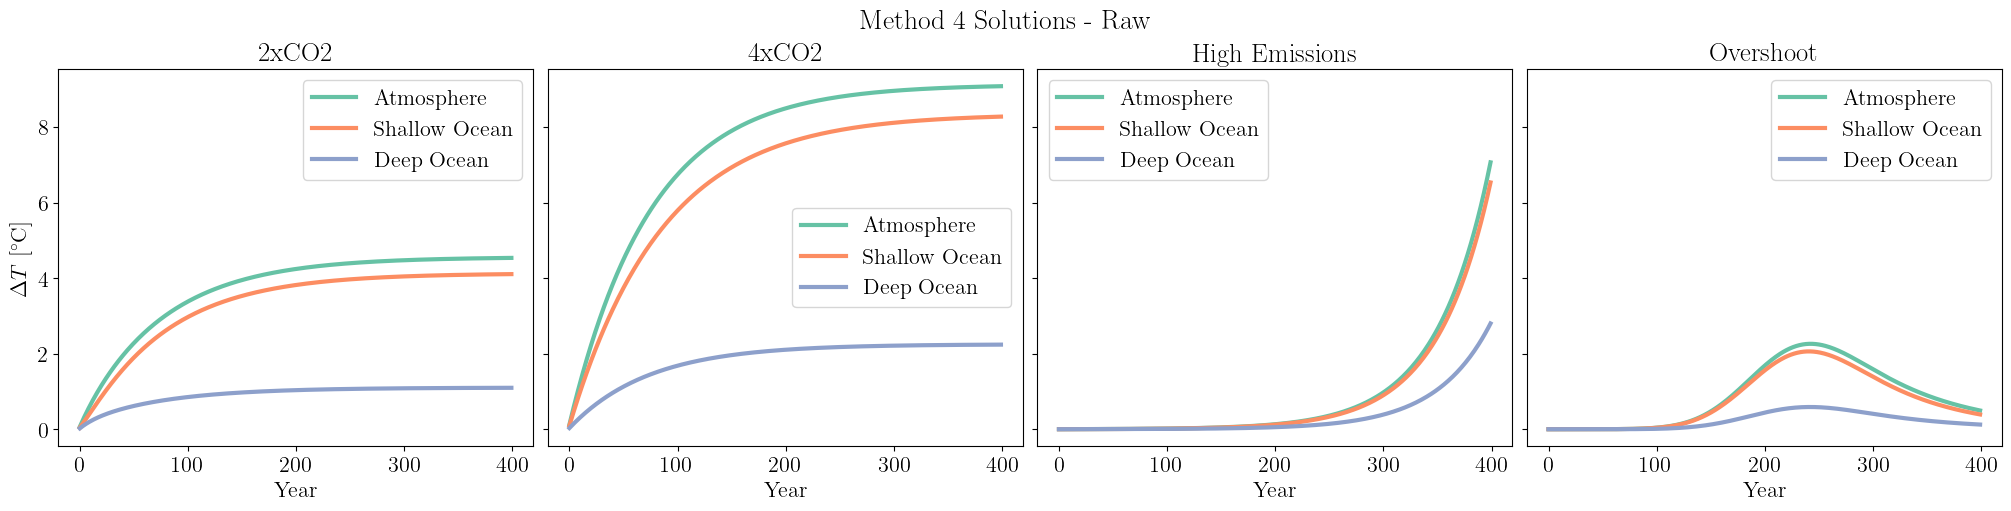

In [23]:
m, k = 2, 3
T_raw_method_4, T_modal_method_4, G_raw_method_4, G_modal_method_4 = utils_coup.method_4_fit(T_ODE, g_ODE, a_ODE, m, k, modal=False)

[ 1.3457199   1.20333758  0.33391203 -0.68237404 -0.34869207  1.02711634
 -0.01255949  0.        ]
[ 0.80367107  0.71863937  0.19941427  2.07436206  1.06017676 -3.12253071
 -0.0125595   0.        ]
[ 1.16388188  1.07617278  0.46132436  0.26445884 -1.10702     0.84256096
 -0.01251907 -0.01702298]
[ 0.90122034  0.80761456  0.23349706  0.44287197  0.64856818  1.22893042
 -0.01253326 -0.34912508]
Error from Raw estimation.
	L2 Error, 2xCO2: 144.69734
	L2 Error, 4xCO2: 184.20167
	L2 Error, High Emissions: 27.39923
	L2 Error, Overshoot: 25.58446
Avg. L2 Error: 95.47068



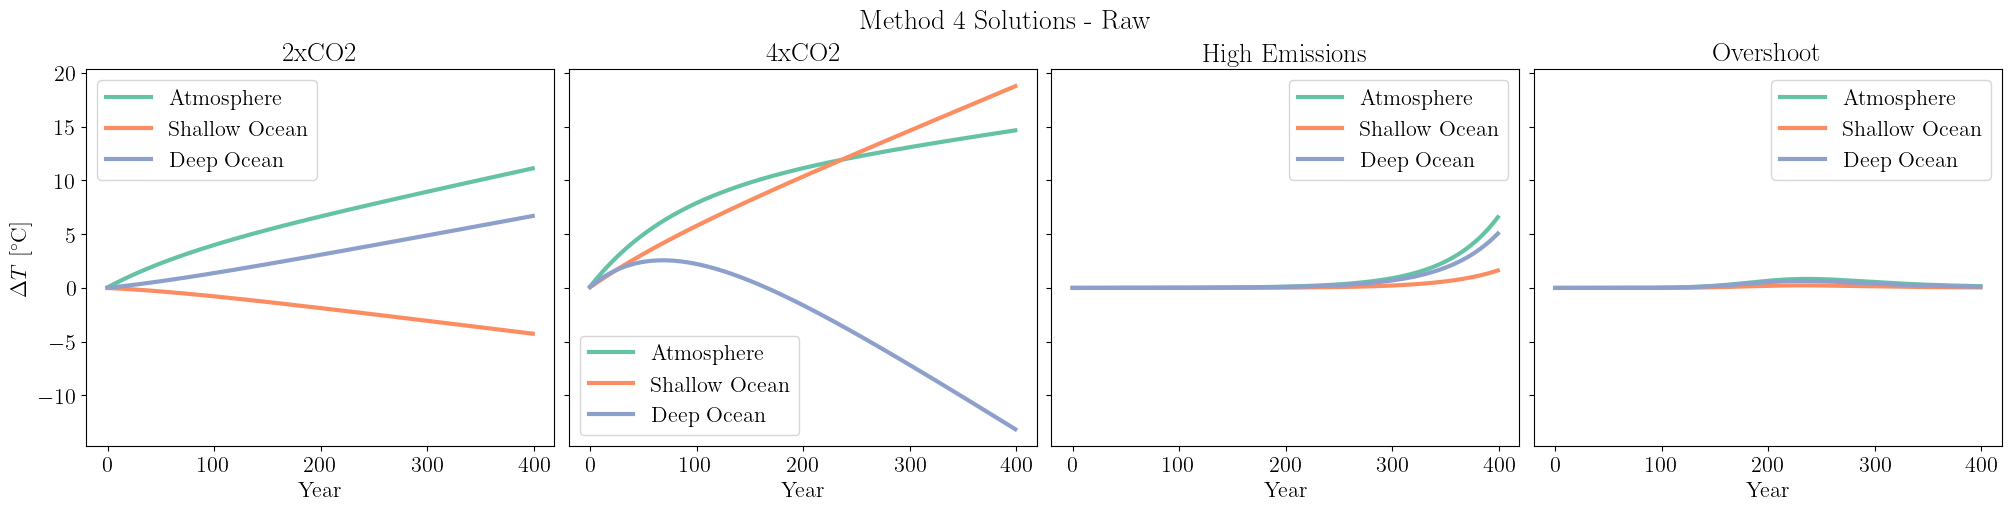

In [92]:
m, k = 2, 3
T_raw_method_4, T_modal_method_4, G_raw_method_4, G_modal_method_4 = utils_coup.method_4_fit_residual(T_ODE, g_ODE, a_ODE, m, k, modal=False)

##### a.iii) All timescales

Error from Raw estimation.
	L2 Error, 2xCO2: 0.50216
	L2 Error, 4xCO2: 0.9982
	L2 Error, High Emissions: 0.00748
	L2 Error, Overshoot: 0.36846
Avg. L2 Error: 0.46908



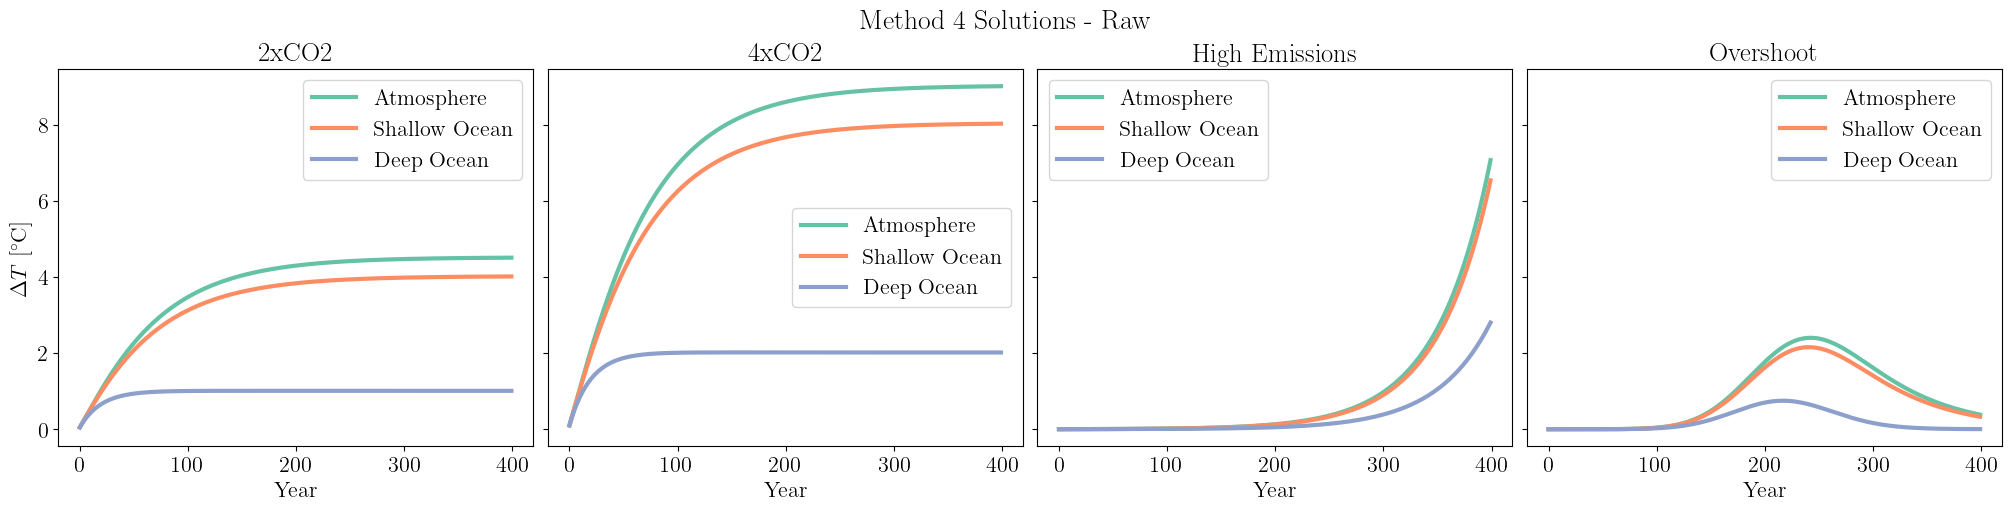

In [24]:
m, k = 3, 3
T_raw_method_4, T_modal_method_4, G_raw_method_4, G_modal_method_4 = utils_coup.method_4_fit(T_ODE, g_ODE, a_ODE, m, k, modal=False)